#"Do the best you can until you know better. Then when you know better, do better."

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture wich has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Sun Aug 21 22:23:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [2]:
# Get the data (10% of 10 food classes from Food101) - https://www.kagge.com/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-21 22:23:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  53.3MB/s    in 3.0s    

2022-08-21 22:23:13 (53.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Creating data loaders (preparing the data)
We'll ise the `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup global variables (capitals = hyperparameter that's gonna be used somewhere else)
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Setup directories
train_dir= "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical") # categorical for multiclass classification, binary for two classes

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking expirements with the `TensorBoard` callback
* Model checkpoint with `ModelCheckpoint`callback
* Stopping a model from training (before it trains to long ad overfits) with the `EarlyStopping`callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new on for each model)
import datetime # for time and date

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir`parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are ging to come from TensorFlow Hub.

We can access pretrained models on : [TensorFlowHub](https://tfhub.dev/)

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a creat_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub Url and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output laer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freez the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # hack to make IMAGE_SHAPE to (224, 224, 3)

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
train_data_10_percent.num_classes

10

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Compile our ResNet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
# Fit the model
rensnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])                                 


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220821-222332
Epoch 1/5
24/24 [==============================] - 35s 774ms/step - loss: 1.9573 - accuracy: 0.3440 - val_loss: 1.2336 - val_accuracy: 0.6004
Epoch 2/5
24/24 [==============================] - 17s 742ms/step - loss: 0.9231 - accuracy: 0.7213 - val_loss: 0.8706 - val_accuracy: 0.7232
Epoch 3/5
24/24 [==============================] - 16s 677ms/step - loss: 0.6432 - accuracy: 0.8173 - val_loss: 0.7688 - val_accuracy: 0.7504
Epoch 4/5
24/24 [==============================] - 16s 682ms/step - loss: 0.4850 - accuracy: 0.8773 - val_loss: 0.7039 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 16s 675ms/step - loss: 0.3836 - accuracy: 0.9107 - val_loss: 0.6950 - val_accuracy: 0.7716


In [14]:
import matplotlib.pyplot as plt

In [15]:
# Let's create a function to plot our loss curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history: Tensorflow History object.
  
  Returns:
    Plots of training/validation loss accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

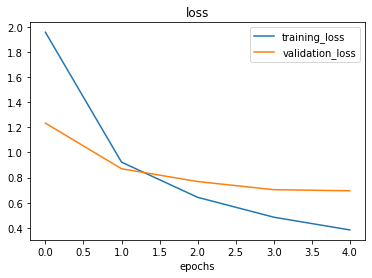

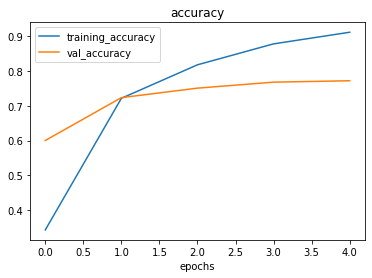

In [16]:
plot_loss_curves(rensnet_history)

### Creating and testing EfficentNetB0 TensorFlow Hub Feature Extraction model

In [17]:
# Create the model
efficenet_model = create_model(efficientnet_url,
                               num_classes=train_data_10_percent.num_classes)

In [18]:
efficenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
# Compile the model
efficenet_model.compile(loss="categorical_crossentropy", # for multiclass classification
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [20]:
# Fit the model
efficenet_history = efficenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="efficentNetB0 ")])

Saving TensorBoard log files to: tensorflow_hub/efficentNetB0 /20220821-222524
Epoch 1/5
24/24 [==============================] - 29s 1s/step - loss: 1.9377 - accuracy: 0.3933 - val_loss: 1.3662 - val_accuracy: 0.7076
Epoch 2/5
24/24 [==============================] - 17s 747ms/step - loss: 1.0954 - accuracy: 0.7480 - val_loss: 0.8905 - val_accuracy: 0.8080
Epoch 3/5
24/24 [==============================] - 15s 662ms/step - loss: 0.7696 - accuracy: 0.8053 - val_loss: 0.7057 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 17s 722ms/step - loss: 0.6187 - accuracy: 0.8587 - val_loss: 0.6145 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 15s 653ms/step - loss: 0.5179 - accuracy: 0.8880 - val_loss: 0.5600 - val_accuracy: 0.8640


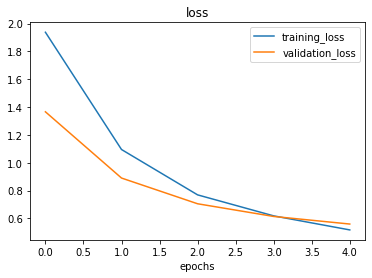

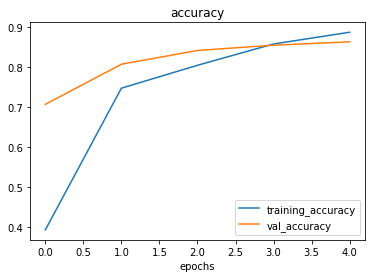

In [21]:
plot_loss_curves(efficenet_history)

### Creating and testing EfficentNetB7 TensorFlow Hub Feature Extraction model

In [22]:
efficenetb7_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"

In [23]:
#Create the model
efficenetb7_model = create_model(efficenetb7_url,
                                 num_classes=train_data_10_percent.num_classes)
# Compile the model
efficenetb7_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])
# Fit the model
b7_history = efficenetb7_model.fit(train_data_10_percent,
                                   epochs=5,
                                   steps_per_epoch=len(train_data_10_percent),
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="efficientnetb7")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb7/20220821-222742
Epoch 1/5
24/24 [==============================] - 88s 2s/step - loss: 1.6124 - accuracy: 0.5413 - val_loss: 0.9602 - val_accuracy: 0.7992
Epoch 2/5
24/24 [==============================] - 37s 2s/step - loss: 0.8081 - accuracy: 0.8040 - val_loss: 0.6712 - val_accuracy: 0.8332
Epoch 3/5
24/24 [==============================] - 37s 2s/step - loss: 0.5999 - accuracy: 0.8533 - val_loss: 0.5825 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 37s 2s/step - loss: 0.4855 - accuracy: 0.8880 - val_loss: 0.5300 - val_accuracy: 0.8484
Epoch 5/5
24/24 [==============================] - 39s 2s/step - loss: 0.4162 - accuracy: 0.9053 - val_loss: 0.4991 - val_accuracy: 0.8620


In [24]:
efficenetb7_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2560)             64097680  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                25610     
                                                                 
Total params: 64,123,290
Trainable params: 25,610
Non-trainable params: 64,097,680
_________________________________________________________________


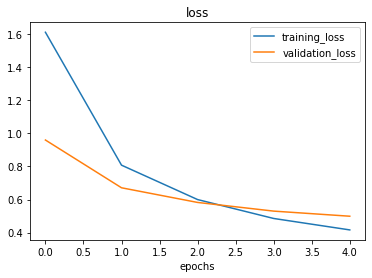

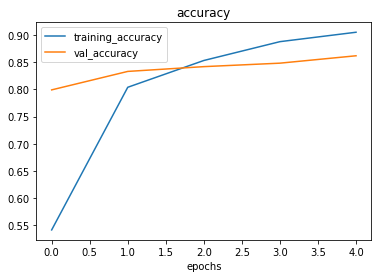

In [25]:
plot_loss_curves(b7_history)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 imageNet classes,none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine_tune" many or all of the underlying layers (including new output layers).

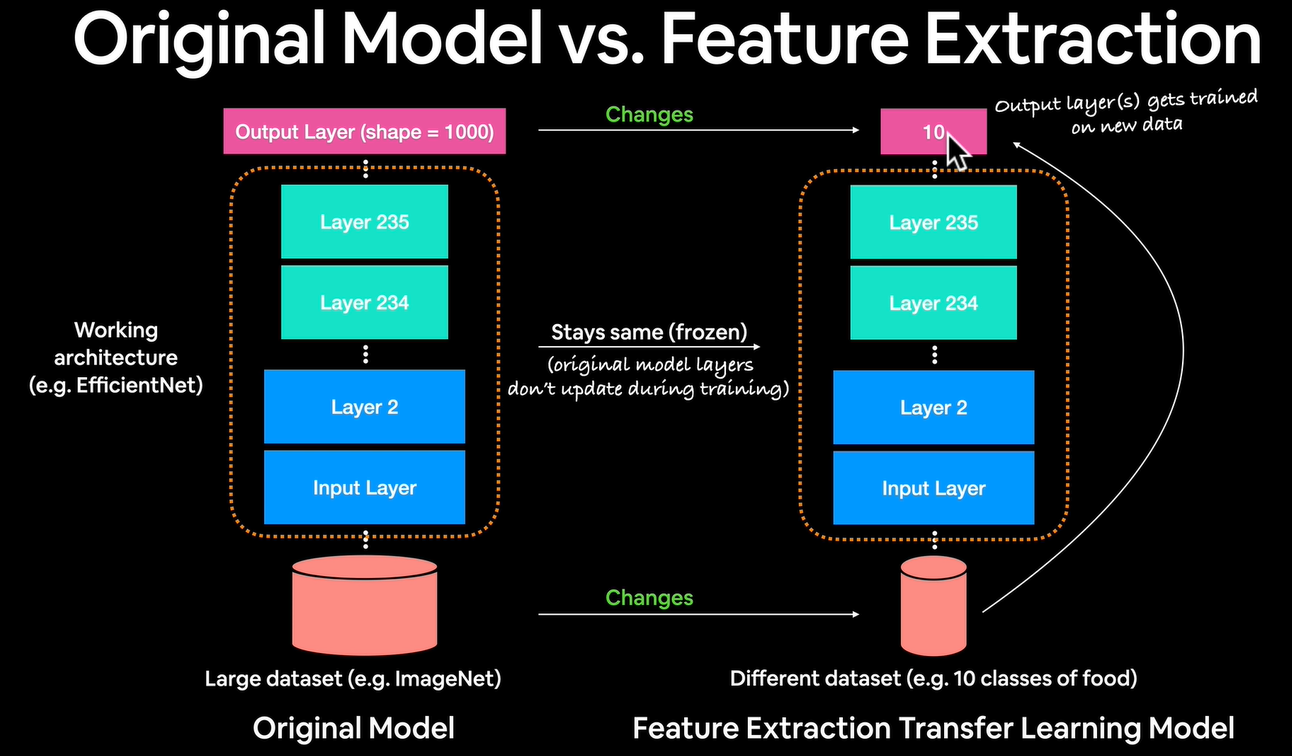

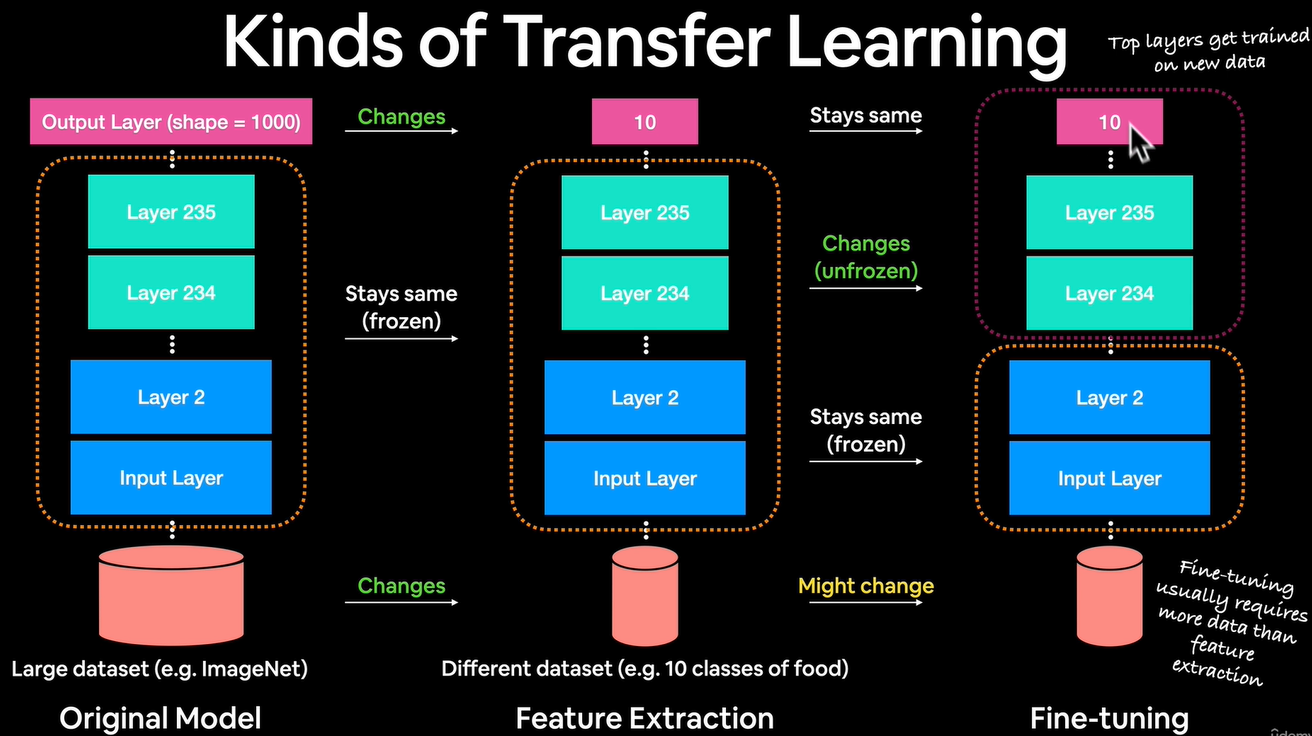

## Comparing our models results using TensorBoard
🔑 **Note:** When you upload things to TensorBoard.dev, your experiments are public. 

In [26]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2 vs. EfficientNtB7" \
  --description "Comparing three different TF Hub feature extraction model architecures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/0lvPG9KvSYGCv3NdkOh3Zw/

In [27]:
# Check out what Tensorboard experiments you have
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


In [28]:
# Delete an expirement
#!tensorboard dev delete --experiment_id 0lvPG9KvSYGCv3NdkOh3Zw

### Transfer Learning in TensorFlow Part1: Feature Extraction Exercises

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
  * You can use any feature extraction layer from TensorFlow Hub you like for this.
  *  You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.

4. What is the current best performing model on ImageNet?

### 1.

In [30]:
MobileNetV2_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [31]:
# Create the MobileNetV2 model
mobileNetV2_model = create_model(MobileNetV2_url,
                                 num_classes=train_data_10_percent.num_classes)
# Compile the model
mobileNetV2_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])
# Fit the model
V2_history = mobileNetV2_model.fit(train_data_10_percent,
                                   epochs=5,
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="mobileNetV2N")])

Saving TensorBoard log files to: tensorflow_hub/mobileNetV2N/20220821-224015
Epoch 1/5
24/24 [==============================] - 20s 654ms/step - loss: 1.9602 - accuracy: 0.3227 - val_loss: 1.3014 - val_accuracy: 0.6132
Epoch 2/5
24/24 [==============================] - 14s 621ms/step - loss: 1.0252 - accuracy: 0.7227 - val_loss: 0.9208 - val_accuracy: 0.7192
Epoch 3/5
24/24 [==============================] - 16s 682ms/step - loss: 0.7276 - accuracy: 0.7933 - val_loss: 0.7338 - val_accuracy: 0.7888
Epoch 4/5
24/24 [==============================] - 14s 621ms/step - loss: 0.5742 - accuracy: 0.8493 - val_loss: 0.6706 - val_accuracy: 0.7952
Epoch 5/5
24/24 [==============================] - 14s 622ms/step - loss: 0.4823 - accuracy: 0.8747 - val_loss: 0.6417 - val_accuracy: 0.8068


In [32]:
mobileNetV2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


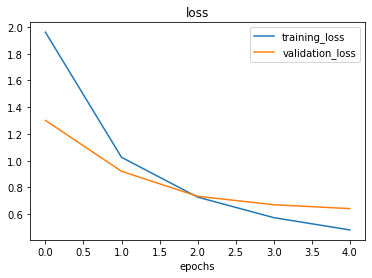

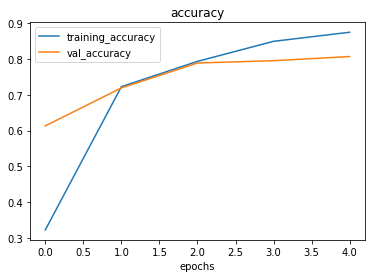

In [33]:
plot_loss_curves(V2_history)

## 3.

In [35]:
# Get the data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
# Getting the data paths
data_dir = 'drive/MyDrive/CNN_dataset'
cup_path = 'drive/MyDrive/CNN_dataset/Cups'
toilet_paper_path = 'drive/MyDrive/CNN_dataset/Toilet_paper'

In [37]:
# Import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.3)
# Turn the data into batches
train_data = train_datagen.flow_from_directory(data_dir,
                                               batch_size=2,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               seed=32,
                                               subset='training')
valid_data = train_datagen.flow_from_directory(data_dir,
                                               batch_size=2,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               seed=32,
                                               subset='validation')

Found 14 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [48]:
# Using the image dataset from directory to read in the data 
train_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir , 
                                                                 labels = 'inferred', 
                                                                 image_size = IMAGE_SHAPE , 
                                                                 batch_size = 8)

Found 20 files belonging to 2 classes.


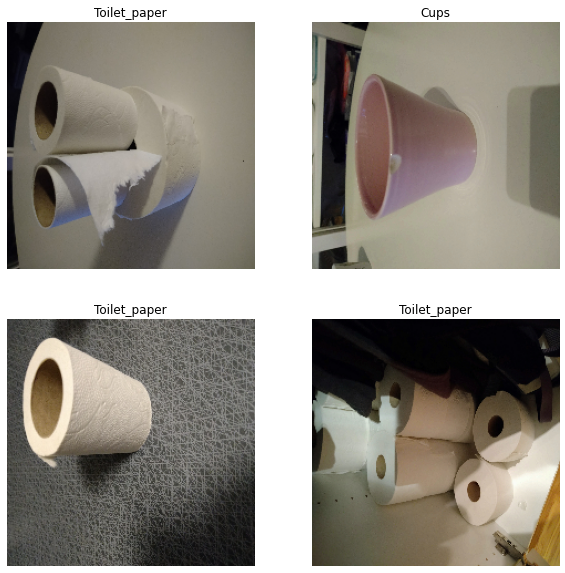

In [49]:
# Let's visualize how our data looks like! 

plt.figure(figsize=(10, 10))
class_names = train_data.class_names
for images, labels in train_data.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [51]:
# Downloading the pretrained model and saving it as a Keras layer 
mobilenet_feature_extraction_layer = hub.KerasLayer(efficenetb7_url ,
                                                    trainable = False , 
                                                    input_shape = IMAGE_SHAPE + (3,))

In [55]:
# Build the model
B7_model_2 = tf.keras.Sequential([
  mobilenet_feature_extraction_layer, 
  layers.Dense(1 , activation= 'sigmoid' , name ='output_layer')                            
])
# Compile the model
B7_model_2.compile(loss="binary_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])
# Fit the model
B7_model_2_history = B7_model_2.fit(train_data,
                                    epochs=15,
                                    steps_per_epoch=len(train_data),
                                    validation_data=valid_data)

Epoch 1/15
3/3 [==============================] - 15s 3s/step - loss: 9.7658 - accuracy: 0.4000 - val_loss: 0.7917 - val_accuracy: 0.3333
Epoch 2/15
3/3 [==============================] - 3s 741ms/step - loss: 2.9478 - accuracy: 0.6000 - val_loss: 0.7829 - val_accuracy: 0.3333
Epoch 3/15
3/3 [==============================] - 4s 1s/step - loss: 1.8980 - accuracy: 0.7500 - val_loss: 0.7754 - val_accuracy: 0.3333
Epoch 4/15
3/3 [==============================] - 3s 724ms/step - loss: 1.5606 - accuracy: 0.7000 - val_loss: 0.7742 - val_accuracy: 0.3333
Epoch 5/15
3/3 [==============================] - 3s 739ms/step - loss: 0.3405 - accuracy: 0.8000 - val_loss: 0.7751 - val_accuracy: 0.3333
Epoch 6/15
3/3 [==============================] - 3s 729ms/step - loss: 0.2899 - accuracy: 0.9000 - val_loss: 0.7762 - val_accuracy: 0.3333
Epoch 7/15
3/3 [==============================] - 3s 725ms/step - loss: 0.5024 - accuracy: 0.8500 - val_loss: 0.7764 - val_accuracy: 0.3333
Epoch 8/15
3/3 [=========

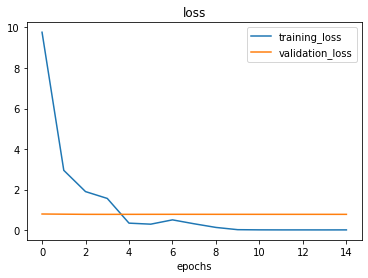

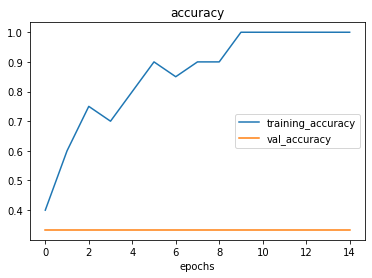

In [56]:
plot_loss_curves(B7_model_2_history)

In [61]:
# Writing a function to import and image and resize it to be used with model predict
def load_and_prep_image(filename , img_shape = 224):
  # Read in the target image 
  img = tf.io.read_file(filename)

  # Decoding into a tensor 
  img = tf.image.decode_image(img , channels = 3)

  # Resize the image(same size as the model trained on)
  img = tf.image.resize(img , size = [img_shape , img_shape])

  # Rescale the image 
  img = img / 255.

  return img

In [57]:
# Creating a function to make prediction and display it

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img , axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [58]:
test = "drive/MyDrive/CNN_dataset/Cups/DSC_6741.JPG"

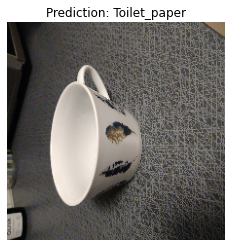

In [62]:
# Getting our class names 
class_names = train_data.class_names

# Using the function to plot our prediction
pred_and_plot(B7_model_2 , test , class_names)